In [1]:
import random
from torch.utils.data import Dataset
import os
import torch
import numpy as np
import pickle
from torchvision import transforms
from PIL import Image
import torchvision
import cv2
import time
import torch.nn.functional as F

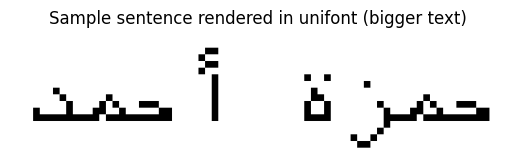

In [9]:
import arabic_reshaper
from bidi.algorithm import get_display
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import numpy as np

# Path to your unifont OTF file (ensure it supports Arabic)
font_path = "./unifont-16.0.02.otf"  # Adjust this path as needed

# Use a larger font size (e.g., 64 instead of 16) to make the text bigger.
font_size = 128  
font = ImageFont.truetype(font_path, font_size)

# Define a sample Arabic sentence.
sample_sentence = "حمزة أحمد" 

# Reshape the Arabic text for proper contextual forms.
reshaped_text = arabic_reshaper.reshape(sample_sentence)
# Reorder for correct right-to-left display.
bidi_text = get_display(reshaped_text)

# Create a new image with a white background.
# Increase the canvas size to accommodate the larger text.
img = Image.new("L", (600, 150), color=255)
draw = ImageDraw.Draw(img)

# Draw the reshaped and bidi-corrected text in black.
draw.text((20, 20), bidi_text, font=font, fill=0)

# Convert the image to a NumPy array and display it.
plt.imshow(np.array(img), cmap='gray')
plt.axis("off")
plt.title("Sample sentence rendered in unifont (bigger text)")
plt.show()


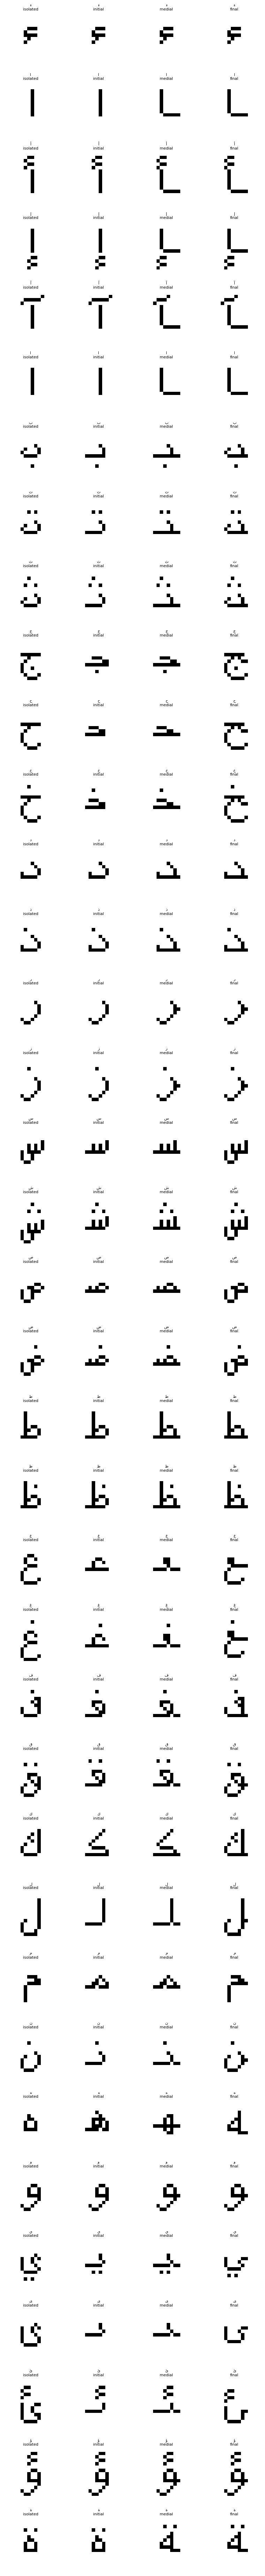

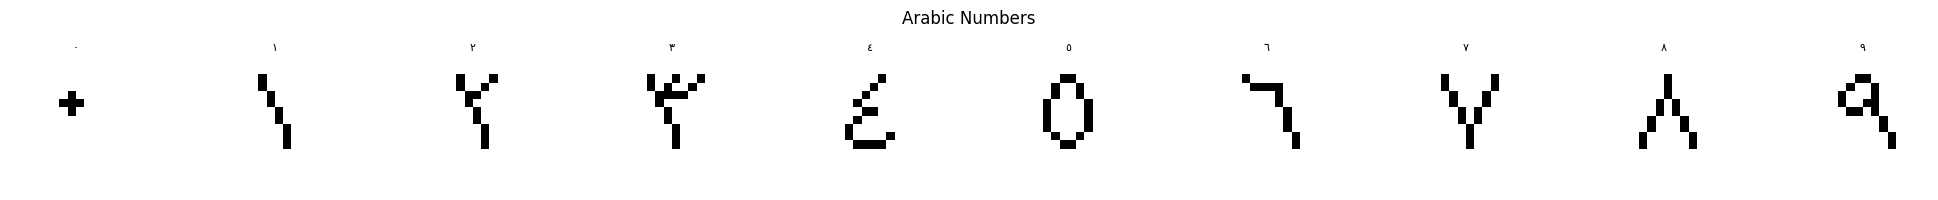

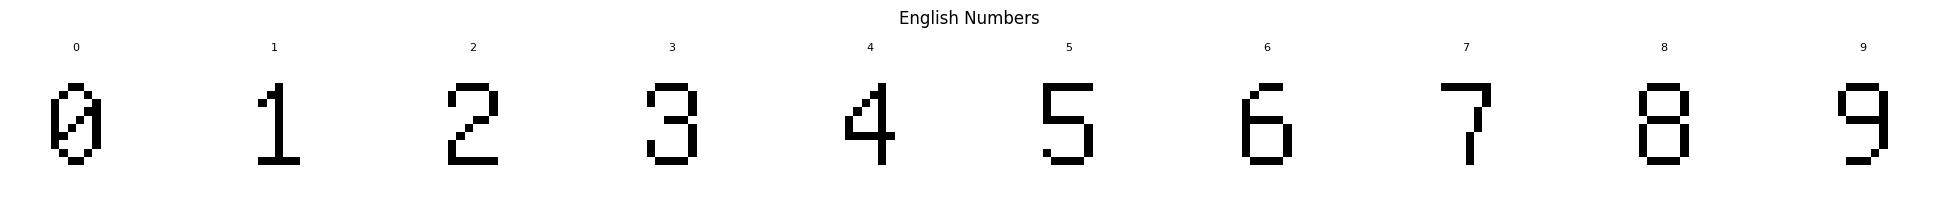

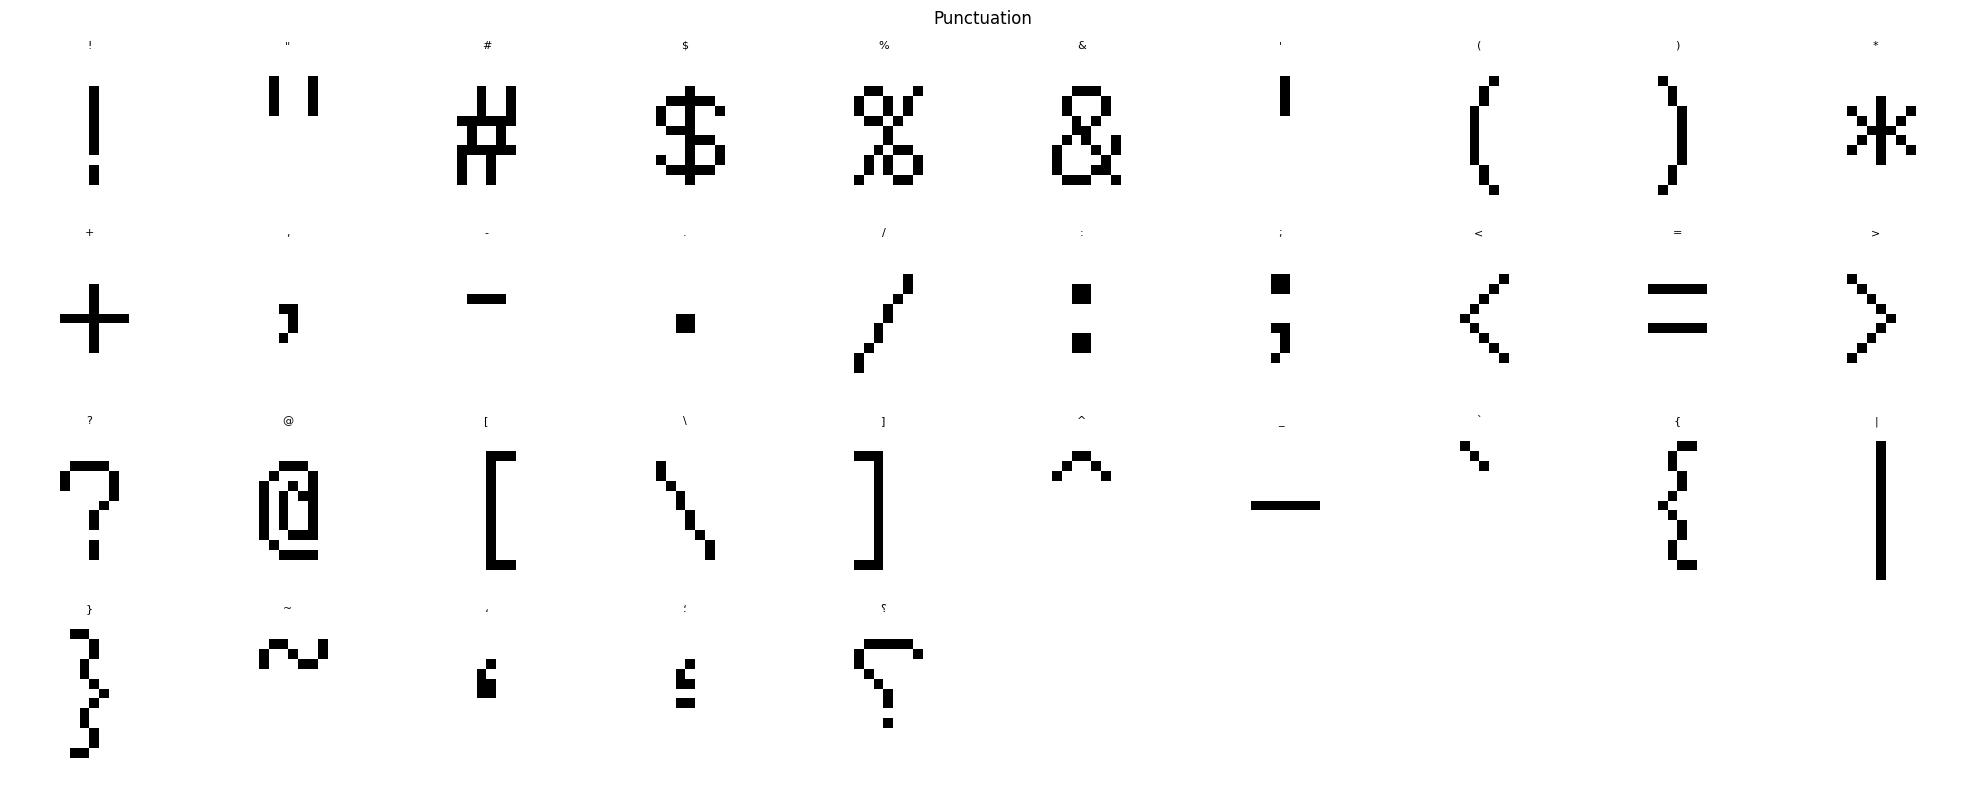

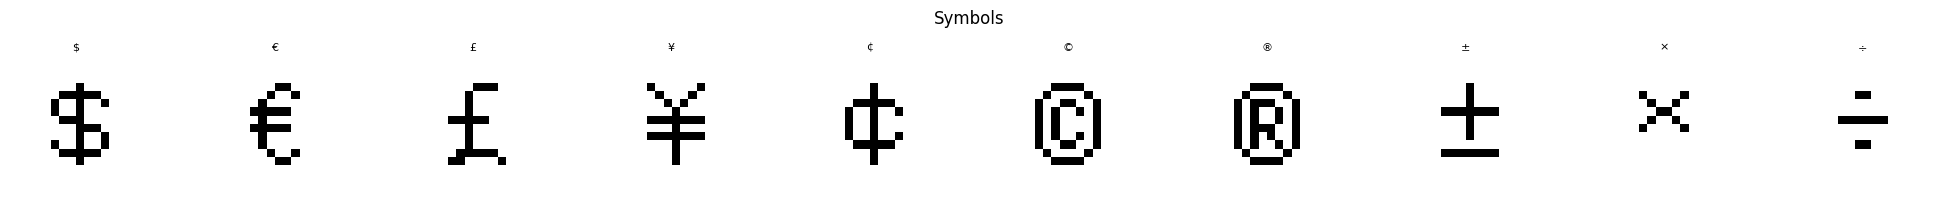

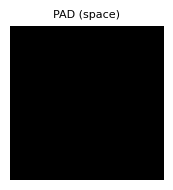

Expanded Arabic unifont (including numbers, punctuation, symbols, and PAD) pickle and PDFs created and saved successfully.


In [12]:
import arabic_reshaper
from bidi.algorithm import get_display
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt
import pickle

# === Character Groups ===

# Arabic letters (expanded, including extra forms such as أ, إ, آ, etc.)
arabic_chars = "ءاأإآابتثجحخدذرزسشصضطظعغفقكلمنهويىئؤة"

# Arabic numbers (Eastern Arabic digits)
arabic_numbers = "٠١٢٣٤٥٦٧٨٩"

# English numbers
english_numbers = "0123456789"

# Punctuation: includes both standard ASCII punctuation and Arabic-specific punctuation
punctuation = "!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~،؛؟"

# Symbols: a few common symbols (you can expand this list as needed)
symbols = "$€£¥¢©®±×÷"

# === Font Setup ===
font_path = "./unifont-16.0.02.otf"  # Adjust this path as needed
font_size = 16  # Native unifont resolution
font = ImageFont.truetype(font_path, font_size)

# === Shaping for Arabic Letters ===
def get_shaped_form(letter, form):
    """
    Create an artificial string to force the target letter into a specific contextual form.
    Forms: "isolated", "initial", "medial", "final".
    Uses a dummy connecting letter (here "س") to force joining.
    """
    dummy = "س"
    if form == "isolated":
        s = letter
    elif form == "initial":
        s = letter + dummy
    elif form == "medial":
        s = dummy + letter + dummy
    elif form == "final":
        s = dummy + letter
    else:
        s = letter
    reshaped = arabic_reshaper.reshape(s)
    bidi_text = get_display(reshaped)
    if form == "isolated":
        return bidi_text
    elif form == "initial":
        return bidi_text[-1]
    elif form == "medial":
        return bidi_text[1]
    elif form == "final":
        return bidi_text[0]

# === Glyph Rendering ===
def render_glyph(text):
    """
    Render the given text (a single character or glyph) on a 16x16 white canvas using
    the native unifont resolution. This preserves the original pixellated look.
    """
    img = Image.new("L", (font_size, font_size), color=255)
    draw = ImageDraw.Draw(img)
    # Compute text bounding box and center the text.
    bbox = draw.textbbox((0, 0), text, font=font)
    text_width = bbox[2] - bbox[0]
    text_height = bbox[3] - bbox[1]
    position = ((font_size - text_width) // 2 - bbox[0],
                (font_size - text_height) // 2 - bbox[1])
    draw.text(position, text, font=font, fill=0)
    # Convert to NumPy array and binarize: background True, ink False.
    img_array = np.array(img)
    binary_array = (img_array >= 128)
    return binary_array

# === Generate Glyph Data ===
# We'll build a dictionary with keys for each character.
# For Arabic letters we generate 4 contextual forms.
# For the non-joining characters (numbers, punctuation, symbols) we generate a single form "default".
glyph_data = {}

# Process Arabic letters with contextual forms.
forms = ["isolated", "initial", "medial", "final"]
for letter in arabic_chars:
    glyph_data[letter] = {}
    for form in forms:
        shaped = get_shaped_form(letter, form)
        binary_img = render_glyph(shaped)
        glyph_data[letter][form] = binary_img

# Process non-joining characters.
for group in [arabic_numbers, english_numbers, punctuation, symbols]:
    for char in group:
        glyph_data[char] = {"default": render_glyph(char)}

# Add a PAD token as a black 16x16 image.
glyph_data["PAD"] = {"default": np.zeros((16, 16), dtype=bool)}

# === Plotting the Generated Glyphs ===

# 1. Plot Arabic letters (each row is a letter; columns are the four forms).
num_letters = len(arabic_chars)
cols = len(forms)
rows = num_letters
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
for i, letter in enumerate(arabic_chars):
    for j, form in enumerate(forms):
        ax = axes[i, j] if rows > 1 else axes[j]
        ax.imshow(glyph_data[letter][form], cmap='gray')
        ax.set_title(f"{letter}\n{form}", fontsize=8)
        ax.axis('off')
plt.tight_layout()
plt.savefig("./unifont_arabic_letters.pdf", bbox_inches='tight')
plt.show()

# 2. Function to plot non-joining character groups.
def plot_group(group_chars, group_name):
    count = len(group_chars)
    cols = 10
    rows = (count + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()
    for idx, char in enumerate(group_chars):
        axes[idx].imshow(glyph_data[char]["default"], cmap='gray')
        axes[idx].set_title(f"{char}", fontsize=8)
        axes[idx].axis('off')
    for idx in range(count, len(axes)):
        axes[idx].axis('off')
    plt.suptitle(group_name)
    plt.tight_layout()
    plt.savefig(f"./unifont_{group_name.replace(' ', '_')}.pdf", bbox_inches='tight')
    plt.show()

plot_group(arabic_numbers, "Arabic Numbers")
plot_group(english_numbers, "English Numbers")
plot_group(punctuation, "Punctuation")
plot_group(symbols, "Symbols")

# 3. Plot the PAD token separately.
fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow(glyph_data["PAD"]["default"], cmap='gray')
ax.set_title("PAD (space)", fontsize=8)
ax.axis('off')
plt.tight_layout()
plt.savefig("./unifont_PAD.pdf", bbox_inches='tight')
plt.show()

print("Expanded Arabic unifont (including numbers, punctuation, symbols, and PAD) pickle and PDFs created and saved successfully.")


In [14]:
import arabic_reshaper
from bidi.algorithm import get_display
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import pickle

# === Character Groups ===
arabic_chars   = "ءاأإآابتثجحخدذرزسشصضطظعغفقكلمنهويىئؤة"
arabic_numbers = "٠١٢٣٤٥٦٧٨٩"
english_numbers= "0123456789"
punctuation    = "!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~،؛؟"
symbols        = "$€£¥¢©®±×÷"

# === Font Setup ===
font_path = "./unifont-16.0.02.otf"  # Adjust this path as needed
font_size = 16  # Native unifont resolution
font = ImageFont.truetype(font_path, font_size)

# === Shaping for Arabic Letters ===
def get_shaped_form(letter, form):
    """
    Force a letter into a desired contextual form by inserting a dummy connecting letter.
    Forms: "isolated", "initial", "medial", "final".
    """
    dummy = "س"  # Dummy letter to force joining.
    if form == "isolated":
        s = letter
    elif form == "initial":
        s = letter + dummy
    elif form == "medial":
        s = dummy + letter + dummy
    elif form == "final":
        s = dummy + letter
    else:
        s = letter
    reshaped = arabic_reshaper.reshape(s)
    bidi_text = get_display(reshaped)
    if form == "isolated":
        return bidi_text
    elif form == "initial":
        return bidi_text[-1]
    elif form == "medial":
        return bidi_text[1]
    elif form == "final":
        return bidi_text[0]

# === Glyph Rendering with Baseline Alignment ===
def render_glyph(text):
    """
    Render the given text (a single character/glyph) on a 16x16 black canvas.
    The glyph is aligned to a common baseline using font metrics.
    The resulting NumPy array is binarized: white pixels (the glyph) are True,
    black background is False.
    """
    # Create a black background.
    img = Image.new("L", (font_size, font_size), color=0)
    draw = ImageDraw.Draw(img)
    
    # Get font metrics.
    ascent, descent = font.getmetrics()
    baseline_y = font_size - descent  # Common baseline position in our 16x16 cell.
    
    # Get text bounding box.
    bbox = draw.textbbox((0, 0), text, font=font)
    text_width = bbox[2] - bbox[0]
    text_height = bbox[3] - bbox[1]
    
    # Center horizontally.
    x_pos = (font_size - text_width) // 2 - bbox[0]
    # Align vertically so that the text's baseline is at baseline_y.
    y_pos = baseline_y - ascent
    
    # Draw text in white.
    draw.text((x_pos, y_pos), text, font=font, fill=255)
    
    # Convert image to a NumPy array and binarize.
    img_array = np.array(img)
    binary_array = (img_array >= 128)
    return binary_array

# === Generate Glyph Data Dictionary ===
# For Arabic letters, generate four forms; for non-joining characters, a single "default" form.
glyph_data = {}

# Process Arabic letters.
forms = ["isolated", "initial", "medial", "final"]
for letter in arabic_chars:
    glyph_data[letter] = {}
    for form in forms:
        shaped = get_shaped_form(letter, form)
        binary_img = render_glyph(shaped)
        glyph_data[letter][form] = binary_img

# Process non-joining characters.
for group in [arabic_numbers, english_numbers, punctuation, symbols]:
    for char in group:
        glyph_data[char] = {"default": render_glyph(char)}

# Set the PAD token to be a white 16x16 image.
glyph_data["PAD"] = {"default": np.ones((16, 16), dtype=bool)}

# === Convert glyph_data into a Pickle Structure ===
glyph_entries = []   # List of entries.
letter2index = {}    # Mapping from character to index (or a dict of indices for Arabic letters).

current_idx = 0

# Process Arabic letters: store all four forms.
for letter in arabic_chars:
    letter2index[letter] = {}
    for form in forms:
        entry = {
            "idx": [current_idx],
            "char": letter,
            "form": form,
            "mat": glyph_data[letter][form]
        }
        glyph_entries.append(entry)
        letter2index[letter][form] = current_idx
        current_idx += 1

# Process non-joining characters.
non_joining_groups = [arabic_numbers, english_numbers, punctuation, symbols]
for group in non_joining_groups:
    for char in group:
        entry = {
            "idx": [current_idx],
            "char": char,
            "form": "default",
            "mat": glyph_data[char]["default"]
        }
        glyph_entries.append(entry)
        letter2index[char] = current_idx
        current_idx += 1

# Add the PAD token.
entry = {
    "idx": [current_idx],
    "char": "PAD",
    "form": "default",
    "mat": glyph_data["PAD"]["default"]
}
glyph_entries.append(entry)
letter2index["PAD"] = current_idx
current_idx += 1

# Build the final data dictionary.
data = {
    "glyph_entries": glyph_entries,
    "letter2index": letter2index
}

# Save the pickle file.
with open("unifont_arabic.pickle", "wb") as f:
    pickle.dump(data, f)

print("Expanded Arabic unifont pickle file created and saved successfully.")


Expanded Arabic unifont pickle file created and saved successfully.


In [15]:
import pickle
import numpy as np

pickle_path = "./unifont_arabic.pickle"  # Adjust path if necessary

with open(pickle_path, "rb") as f:
    data = pickle.load(f)

glyph_entries = data["glyph_entries"]

# Display detailed info for the first 10 entries.
for i, entry in enumerate(glyph_entries[:10]):
    print(f"Entry {i}:")
    print("  idx:", entry["idx"])
    print("  char:", entry["char"])
    print("  form:", entry["form"])
    print("  mat shape:", entry["mat"].shape)
    print("  mat dtype:", entry["mat"].dtype)
    # Calculate the pixel sum (for binary images, sum gives the number of white pixels if white==True)
    pixel_sum = np.sum(entry["mat"])
    print("  Pixel sum:", pixel_sum)
    # List unique values in the matrix
    unique_values = np.unique(entry["mat"])
    print("  Unique values:", unique_values)
    print("-" * 40)


Entry 0:
  idx: [0]
  char: ء
  form: isolated
  mat shape: (16, 16)
  mat dtype: bool
  Pixel sum: 10
  Unique values: [False  True]
----------------------------------------
Entry 1:
  idx: [1]
  char: ء
  form: initial
  mat shape: (16, 16)
  mat dtype: bool
  Pixel sum: 10
  Unique values: [False  True]
----------------------------------------
Entry 2:
  idx: [2]
  char: ء
  form: medial
  mat shape: (16, 16)
  mat dtype: bool
  Pixel sum: 10
  Unique values: [False  True]
----------------------------------------
Entry 3:
  idx: [3]
  char: ء
  form: final
  mat shape: (16, 16)
  mat dtype: bool
  Pixel sum: 10
  Unique values: [False  True]
----------------------------------------
Entry 4:
  idx: [4]
  char: ا
  form: isolated
  mat shape: (16, 16)
  mat dtype: bool
  Pixel sum: 8
  Unique values: [False  True]
----------------------------------------
Entry 5:
  idx: [5]
  char: ا
  form: initial
  mat shape: (16, 16)
  mat dtype: bool
  Pixel sum: 8
  Unique values: [False  True]


In [16]:
import pickle

pickle_path = "./unifont_arabic.pickle"  # adjust this path as necessary

with open(pickle_path, "rb") as f:
    data = pickle.load(f)

glyph_entries = data['glyph_entries']
letter2index = data['letter2index']

# Total number of glyph entries:
total_entries = len(glyph_entries)
print("Total glyph entries:", total_entries)

print("\nMapping from characters to indices:")
for char, mapping in letter2index.items():
    # For Arabic letters, mapping is a dictionary (forms).
    if isinstance(mapping, dict):
        print(f"Character: {char}")
        for form, idx in mapping.items():
            print(f"  Form: {form} -> Index: {idx}")
    else:
        print(f"Character: {char} -> Index: {mapping}")

# If you want a list of all characters stored (keys in the mapping):
all_chars = list(letter2index.keys())
print("\nAll characters present:")
print(all_chars)


Total glyph entries: 214

Mapping from characters to indices:
Character: ء
  Form: isolated -> Index: 0
  Form: initial -> Index: 1
  Form: medial -> Index: 2
  Form: final -> Index: 3
Character: ا
  Form: isolated -> Index: 20
  Form: initial -> Index: 21
  Form: medial -> Index: 22
  Form: final -> Index: 23
Character: أ
  Form: isolated -> Index: 8
  Form: initial -> Index: 9
  Form: medial -> Index: 10
  Form: final -> Index: 11
Character: إ
  Form: isolated -> Index: 12
  Form: initial -> Index: 13
  Form: medial -> Index: 14
  Form: final -> Index: 15
Character: آ
  Form: isolated -> Index: 16
  Form: initial -> Index: 17
  Form: medial -> Index: 18
  Form: final -> Index: 19
Character: ب
  Form: isolated -> Index: 24
  Form: initial -> Index: 25
  Form: medial -> Index: 26
  Form: final -> Index: 27
Character: ت
  Form: isolated -> Index: 28
  Form: initial -> Index: 29
  Form: medial -> Index: 30
  Form: final -> Index: 31
Character: ث
  Form: isolated -> Index: 32
  Form: init

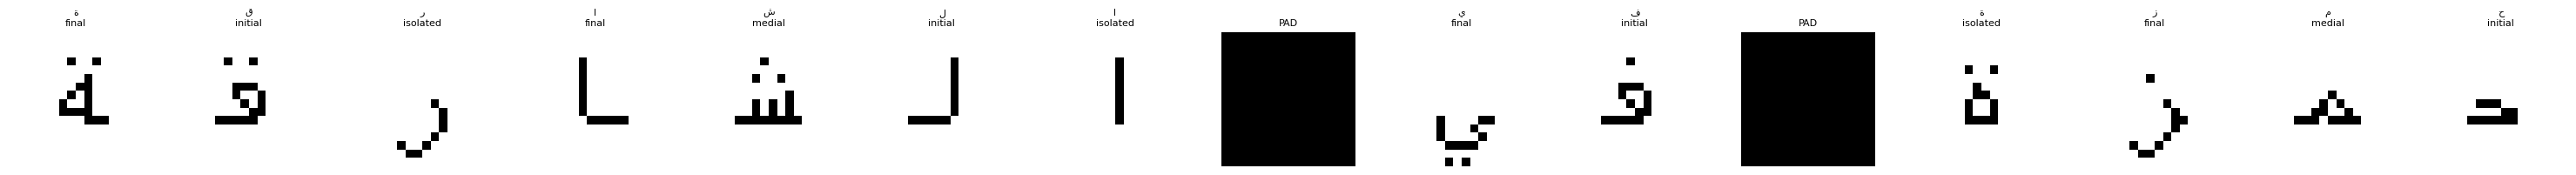

In [19]:
import pickle
import torch
import matplotlib.pyplot as plt
import numpy as np

# --- Character Groups ---
arabic_chars   = "ءاأإآابتثجحخدذرزسشصضطظعغفقكلمنهويىئؤة"
arabic_numbers = "٠١٢٣٤٥٦٧٨٩"
english_numbers= "0123456789"
punctuation    = "!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~،؛؟"
symbols        = "$€£¥¢©®±×÷"

# --- Load the Pickle File and Build the Glyph Tensor ---
def load_unifont_arabic(pickle_path="./unifont_arabic.pickle"):
    with open(pickle_path, "rb") as f:
        data = pickle.load(f)
    glyph_entries = data['glyph_entries']
    letter2index = data['letter2index']
    total = len(glyph_entries)
    # Build a list of glyphs based on their stored index.
    glyph_list = [None] * total
    for entry in glyph_entries:
        idx = entry['idx'][0]
        glyph_list[idx] = torch.from_numpy(entry['mat'].astype(np.float32))
    con_symbols = torch.stack(glyph_list)  # Tensor shape: (total, 16, 16)
    return con_symbols, letter2index

# --- Updated Joining Heuristic with Label Output ---
def shape_arabic_text(text, letter2index):
    """
    For each character in the input text, choose the contextual form
    based on its neighbors using a joining heuristic.
    
    We define a set of non-joining letters (which do not connect to the following letter):
      non_joining = {"ا", "أ", "إ", "آ", "د", "ذ", "ر", "ز", "و"}
      
    For an Arabic letter:
      - If the letter is in the non-joining set, then if there is a joinable letter
        immediately to its left, use "final"; otherwise, "isolated".
      - Otherwise, if the letter is joinable (not in the non-joining set):
          * Use "medial" if there are joinable neighbors on both sides.
          * Use "final" if there is only a joinable letter before it.
          * Use "initial" if there is only a joinable letter after it.
          * Otherwise, use "isolated".
    
    Returns:
      indices: List of glyph indices (for lookup)
      forms:   List of contextual form labels corresponding to each character.
      
    Finally, both lists are reversed to simulate right-to-left rendering.
    """
    non_joining = set("اأإآدذرزو")
    indices = []
    forms = []
    n = len(text)
    for i, char in enumerate(text):
        if char in arabic_chars:
            # Determine if previous character is joinable (Arabic and not a non-joiner)
            prev_join = (i > 0 and text[i-1] in arabic_chars and text[i-1] not in non_joining)
            # Current letter is joinable if not in non_joining.
            curr_joinable = (char not in non_joining)
            # Next letter is considered joinable if it is an Arabic letter.
            next_join = (i < n - 1 and text[i+1] in arabic_chars)
            
            if not curr_joinable:
                form = "final" if prev_join else "isolated"
            else:
                if prev_join and next_join:
                    form = "medial"
                elif prev_join and not next_join:
                    form = "final"
                elif not prev_join and next_join:
                    form = "initial"
                else:
                    form = "isolated"
            try:
                idx = letter2index[char][form]
            except KeyError:
                idx = letter2index[char]["isolated"]
            indices.append(idx)
            forms.append(form)
        else:
            # For non-Arabic characters use the default form.
            if char in letter2index:
                if isinstance(letter2index[char], dict):
                    idx = letter2index[char]["default"]
                else:
                    idx = letter2index[char]
                form = "default"
            else:
                idx = letter2index["PAD"]
                form = "PAD"
            indices.append(idx)
            forms.append(form)
    
    return list(reversed(indices)), list(reversed(forms))

# --- Get Glyph Images for Input Text ---
def get_content_glyphs(text, con_symbols, letter2index):
    indices, forms = shape_arabic_text(text, letter2index)
    content = con_symbols[indices]
    content = 1.0 - content
    return content, forms

# --- Plotting Function with Detected Labels ---
def plot_glyphs(glyphs, text, labels):
    num_chars = glyphs.shape[0]
    fig, axes = plt.subplots(1, num_chars, figsize=(num_chars * 2, 2))
    if num_chars == 1:
        axes = [axes]
    rev_text = text[::-1]  # Reverse the text for right-to-left display.
    for i, ax in enumerate(axes):
        ax.imshow(glyphs[i].numpy(), cmap='gray')
        # Title shows the reversed character and its contextual form label.
        ax.set_title(f"{rev_text[i]}\n{labels[i]}", fontsize=8)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# --- Example Usage ---
pickle_path = "./unifont_arabic.pickle"  # Adjust path if necessary.
con_symbols, letter2index = load_unifont_arabic(pickle_path)

# Example Arabic text.
# For instance, in "حمزة أحمد" the joining heuristic will decide the correct form for each letter.
example_text = "حمزة في الشارقة"

glyphs, labels = get_content_glyphs(example_text, con_symbols, letter2index)
plot_glyphs(glyphs, example_text, labels)
